# CONTROL TERMAL EN EL COMPORTAMIENTO SISMOGÉNICO DEL MEGATHRUST CHILENO

## ANEXO 3

El siguiente *notebook* corresponde código utilizado para llevar a cabo todos los cálculos

#### Daniel Castro Rebolledo

---

## Importación de librerías

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib.collections import LineCollection

In [80]:
from random import uniform
import seaborn as sns

In [81]:
import pylab as pl
from matplotlib.offsetbox import AnchoredText

In [82]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [83]:
import sys

In [84]:
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


---

## Lectura de datos

#### Archivos .csv

In [85]:
my_dir=os.getcwd()

datos=pd.read_csv(my_dir + '\\BaseDatos\\GrillaTotal.csv')
hf=pd.read_csv(my_dir + '\\BaseDatos\\Mediciones_HeatFlow\\hf.csv')
hf_BSR=pd.read_csv(my_dir + '\\BaseDatos\\Mediciones_HeatFlow\\hf_BSR.csv')
data_sismos=pd.read_csv(my_dir + '\\BaseDatos\\sismos_CSN.csv')
slips=pd.read_csv(my_dir + '\\BaseDatos\\Slips.csv')
Moho=pd.read_csv(my_dir + '\\BaseDatos\\Moho_T&E12.csv')

In [86]:
datos.sample()

,lat,lon,bat_topo,depth,dip,Age_Muller,strike,geometry,azi_trench,vel_trench,...,age_azi,vel_azi,depth_c,distancia_,Moho,carga_lith,fr,crust_dens,Beta,Alpha
29316,-44.65,-75.85,-3309.0,NaN,NaN,NaN,NaN,POINT (-75.84999999999995 -44.65000000000001),NaN,5.14336,...,14.8518,61.846473,NaN,NaN,-24.222557,NaN,NaN,2.728282,1.68805,NaN


In [87]:
data_sismos.sample()

,lon,lat,depth,mag,year,month,day,hour,minute,second,distancia,error_dist,intercorticales,ix_Grilla
71763,-71.298,-30.756,46.0,3.3,2016.0,9.0,20.0,14.0,57.0,45.5,119.642707,0.001561,False,"[12596, 12597, 12676, 12677]"


In [88]:
slips.sample()

,lon,lat,meters,locality,ix_Grilla,Area,pot_sismica
112810,-73.279517,-34.659549,5.267911,Maule10,"[15696, 15697, 15776, 15777]",20.458455,107.773312


In [89]:
hf_BSR.sample()

,lon,lat,HeatFlow_BSR,distancia,error_dist,ix_Grilla
3517,-73.834,-36.665,43.163353,46.03306,0.055855,"[20491, 20492, 20571, 20572]"


In [90]:
hf.sample()

,lon,lat,HeatFlow,method,error,distancia,error_dist,ix_Grilla
229,-62.652,-25.76,73.71,3.0,14.0,890.993941,0.004139,[]


In [91]:
hf_BSR=hf_BSR.assign(method=[5. for i in range(len(hf_BSR))])

In [92]:
hf_BSR.sample()

,lon,lat,HeatFlow_BSR,distancia,error_dist,ix_Grilla,method
41382,-75.622,-44.6106,66.64248,10.125519,8.248738,"[29293, 29294, 29318, 29319]",5.0


#### Shapes

In [93]:
SA_shape=gpd.read_file(my_dir + '\\Shapes\\Sudamérica.shp')
Ciudades=gpd.read_file(my_dir + '\\Shapes\\Ciudades.shp')

In [94]:
lim_moho=gpd.read_file(my_dir + '\\Shapes\\Moho_TE.shp')
trench=gpd.read_file(my_dir + '\\Shapes\\Trench.shp')
epicentros=gpd.read_file(my_dir + '\\Shapes\\Epicentros.shp')

In [95]:
epicentros

,Id,Earthquake,geometry
0,0,Iquique14,POINT (-70.76900 -19.61000)
1,0,Antofa95,POINT (-70.29400 -23.34000)
2,0,Tocopilla07,POINT (-69.89000 -22.24700)
3,0,Illapel15,POINT (-71.67400 -31.57300)
4,0,Maule10,POINT (-72.89800 -36.12200)
5,0,Valdivia60,POINT (-73.40700 -38.14300)


#### Unificación medidas flujo de calor superficial como DataFrame

In [96]:
d={'lon':list(hf_BSR.lon)+list(hf.lon), 'lat':list(hf_BSR.lat)+list(hf.lat), 
   'Q':list(hf_BSR.HeatFlow_BSR)+list(hf.HeatFlow), 'distancia':list(hf_BSR.distancia)+list(hf.distancia),
   'metodo':list(hf_BSR.method)+list(hf.method), 'ix_Grilla':list(hf_BSR.ix_Grilla)+list(hf.ix_Grilla)}

In [97]:
hf_df=pd.DataFrame(d)
hf_df.sample()

,lon,lat,Q,distancia,metodo,ix_Grilla
22335,-73.647,-35.9377,42.764012,36.276306,5.0,"[16653, 16654, 16733, 16734]"


In [98]:
type(hf_df.ix_Grilla[2000])

str

##### Corrección lectura de datos

In [99]:
def PuntosMalla_to_list(secuencia):
    #Desde la base de datos se lee como str, esta fórmula lo transforma a lista para facilitar su manejo
    lista1=secuencia.split(',')
    new_lista=[]
    for i in lista1:
        try:
            i=int(i)
            new_lista.append(i)
        except ValueError:
            try:
                i=i[1:]
                i=int(i)
                new_lista.append(i)
            except ValueError:
                try:
                    i=i[:-1]
                    i=int(i)
                    new_lista.append(i)
                except ValueError:
                    new_lista.append(np.nan)
    return new_lista

Correción a base de datos de Medidas flujo de Calor

In [100]:
hf_df=hf_df.assign(ix_Grilla= [PuntosMalla_to_list(i) for i in hf_df.ix_Grilla])

Correción a base de datos de Slips

In [101]:
slips=slips.assign(ix_Grilla= [PuntosMalla_to_list(i) for i in slips.ix_Grilla])

In [102]:
slips.replace(0, np.nan, inplace=True)

Corrección a base de datos de Sismos

In [103]:
data_sismos=data_sismos.assign(ix_Grilla=[PuntosMalla_to_list(i) for i in data_sismos.ix_Grilla])

Solo se considerarán los sismos del *megathrust*
Para esto, se filtran aquellos ubicados a una distanica **d** de la geometría del Slab2

In [104]:
def sismos_inter(d):
    # d: debe ser un número, unidad de medida kilómetros
    inter=[]
    for ix,z in zip(data_sismos.ix_Grilla, data_sismos.depth):
        Bool=[]
        for j in ix:
            try:
                if datos.iloc[j].depth*-1 +d >= z and datos.iloc[j].depth*-1 -d <= z:
                    Bool.append(True)
                else:
                    Bool.append(False)
            except TypeError:
                Bool.append(False)
        if True in Bool:
            inter.append(True)
        else:
            inter.append(False)
    return inter

In [105]:
data_sismos['intercorticales']=sismos_inter(5)

In [106]:
sismos_thrust=data_sismos[data_sismos.intercorticales==True].copy()
sismos_thrust.sample()

,lon,lat,depth,mag,year,month,day,hour,minute,second,distancia,error_dist,intercorticales,ix_Grilla
45786,-69.831,-21.317,57.2,4.1,2012.0,4.0,1.0,16.0,39.0,6.9,146.957092,0.042398,True,"[3411, 3412, 3491, 3492]"


---

## Asignación de Variables

In [107]:
lon        = datos['lon']
lat        = datos['lat']
depth      = datos['depth_c'] #profundidad corregida desde la fosa
vel_trench = datos['vel_trench']
age_trench = datos['age_trench']
dip        = datos['dip']
bat        = datos['bat_topo']
vel_azi    = datos['vel_azi']
age_azi    = datos['age_azi']
distancia  = datos['distancia_'] #distancia a la fosa
densidad   = datos['crust_dens']

---

## Creación de objetos

In [108]:
class Parametros:
    def __init__(self, nombre='Estándar', depth=depth,
                 tau=20, kc=2.5, ko=2.9, tp=1350, K=1e-6, vel=vel_azi, age=age_azi, dip=dip):
        self.nombre = nombre
        self.lat = lat
        self.lon = lon
        self.depth = depth
        self.tau = pd.Series(tau)        # [MPa] estrés de cizalle
        self.kc = kc            # [W/m°C] Conductividad termal corteza continental
        self.ko = ko            # [W/m°C] Conductividad termal corteza oceanica
        self.tp = tp          # [°C] Temperatura potencial del manto
        self.K = K            # [m2/s] Difusividad termal
        self.vel = pd.Series(vel)
        self.age = pd.Series(age)
        self.dip = pd.Series(dip)
        self.bat = bat
        self.distancia = distancia
        self.ticks= {'lat': 'Latitud', 'lon': 'Longitud', 'depth': 'Profundidad', 'tau': 'Cizalle', 
                     'kc':'Cond. Termal','ko':'Cond. Termal', 'tp':'T° Potencial', 'K': 'Dif. Termal',
                     'vel':'Velocidad', 'age':'Edad', 'dip':'Manteo','T':'Temperatura',
                     'Q': 'Flujo de Calor Superficial', 'bat':'Batimetría y Topografía',
                     'distancia': 'distancia [km]'}
        self.measure_unit={'lat': '°', 'lon': '°', 'depth': 'metros', 'tau': 'MPa','kc':'W/m°C','ko':'W/m°C', 'tp':'°C',
                     'K': 'm2/s', 'vel':'mm/año', 'age':'Ma', 'dip':'°', 'T':'°C', 'Q': 'mW/m2',
                     'bat': 'metros', 'distancia': 'kilómetros'}

    
    def corregir(self):
        #Corrección de unidades de medida
        self.age = self.age*3.15e13                       #Ma a segundos
        self.vel = self.vel*(0.001/3.15e7)                #mm/año a metro/segundo
        self.dip = (np.pi/180)*self.dip                   #grados a radianes
        self.bat = self.bat*-1                            #corrección de signo
        self.tau = self.tau*1e6                           #MPa a Pa
        self.depth = self.depth*-1000                     #Km a m

    def anti_corregir(self, attr):
        #Esta anticorrección SIEMPRE debe usarse multiplicando
        #deveulve el factor que corregirá al atributo en cuestión
        c=1
        
        if attr == 'depth':
            c= -1000**(-1)
            
        if attr == 'age':
            c= 3.15e-13
            
        if attr == 'vel':
            c= (3.15e7/0.001)
        
        if attr == 'dip':
            c=180/np.pi
            
        if attr == 'bat':
            c== -c
            
        if attr == 'tau':
            c= 1e-6
            
        return c

    def temperatura(self):
        #Cálculo de temperatura
        kc        = self.kc
        ko        = self.ko
        depth     = self.depth
        tau       = self.tau
        tp        = self.tp
        K         = self.K
        distancia = self.distancia
        
        if len(self.vel)==1:
            vel=self.vel[0]
        else:
            vel=self.vel
        
        if len(self.age)==1:
            age=self.age[0]
        else:
            age=self.age
        
        if len(self.dip)==1:
            dip=self.dip[0]
        else:
            dip=self.dip
            
        if len(self.tau)==1:
            tau=self.tau[0]
        else:
            tau=self.tau
        
        S=1+np.sqrt((depth*vel*np.sin(dip))/K)
        Qs=(ko*tp)/(np.sqrt(np.pi*K*age))      
        
        Q=(Qs+tau*vel)/S
        
        self.Q=Q*1000
        
        T=(Q*depth)/kc
        self.T=pd.Series(T)
        
    def calcular(self):
        self.corregir()
        self.temperatura()
        
class Test(Parametros):
    def __init__ (self, **kwards):
        super().__init__( **kwards)
        self.calcular()

class Points:
    def __init__(self, lon= None, lat= None, Q= None, depth=None, distancia= None, metodo= None, ix_Grilla= None):
        self.lon = np.array(lon)
        self.lat = np.array(lat)
        self.Q = np.array(Q)
        self.depth = np.array(depth)
        self.distancia = np.array(distancia)
        self.metodo= np.array(metodo)
        self.ix_Grilla= np.array(ix_Grilla)

---

## Teoría NCCW

##### Dahlen, 1984

In [109]:
def beta_prima(lambda_i=0.8):
    # Las unidades de medidas del agua y corteza se expresan en gr/cm3, terminan calcelandose así que no importa mucho
    # La dendidad del agua se aproxima a 1 gr/cm3
    # El resultado está en grados
    Beta=np.radians(datos.Beta)
    return np.degrees(np.arctan(((1-1/datos.crust_dens)/(1-lambda_i))*np.tan(Beta)))

In [134]:
def psi_cero (lambda_i=0.8, fi=47.72631099):  # fi calculado a partir de mu=1.1 --> fi=arctan(mu)
    b_prima     = beta_prima(lambda_i)
    b_prima_rad = np.radians(b_prima)
    fi_rad      = np.radians(fi)
    
    psi_0=[]
    for b_p in b_prima_rad:
        if np.sin(b_p) / np.sin(fi_rad) >1:
            psi_0.append(np.degrees((np.arcsin(1) / 2) - (b_p/2)))
        else:
            psi_0.append(np.degrees(((np.arcsin(np.sin(b_p) / np.sin(fi_rad))) / 2) - (b_p/2)))
    return pd.Series(psi_0), fi

In [112]:
def psi_b (lambda_i=0.8, fi=47.72631099):
    psi_o, f =psi_cero(lambda_i, fi)
    return datos.Alpha + datos.Beta + psi_o, f

In [113]:
def mu_b_prima(lambda_i=0.8, fi=47.72631099):
    psi_be, f = psi_b(lambda_i, fi)
    psi_b_rad = np.radians(psi_be)
    fi_rad        = np.radians(f)
    # lo escribi de otra manera ya que no encontré como escribir cosec y sec en numpy
    return np.sin(2*psi_b_rad) / ((1/np.sin(fi_rad)) - np.cos(2*psi_b_rad)), fi

In [114]:
z = (datos.depth * -1000) - (datos.bat_topo)

In [115]:
def tau_NCCW(lambda_b, fi=40.36453657): 
    mu, fi= mu_b_prima(lambda_b,fi)
    return (mu * (1-lambda_b) * datos.crust_dens*1000 * z * 9.8 * np.cos(np.radians(datos.Alpha)))*1e-6

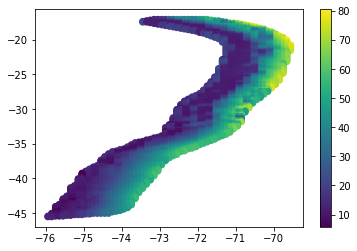

In [128]:
t=tau_NCCW(0.95)
cbr=plt.scatter(datos.lon, datos.lat, c=t)
plt.colorbar(cbr)

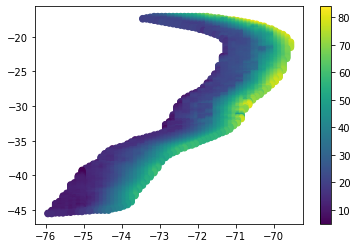

In [130]:
t=tau_NCCW(0.95)
cbr=plt.scatter(datos.lon, datos.lat, c=t)
plt.colorbar(cbr)

---

## Distribución de las medidas del Flujo de Calor Superficial

In [37]:
#Creación de objeto para utilizarlo en las fórmulas siguientes
hf_object=Points(lon         = hf_df.lon, 
                 lat         = hf_df.lat,
                 Q           = hf_df.Q,
                 distancia   = hf_df.distancia,
                 metodo      = hf_df.metodo,
                 ix_Grilla   = hf_df.ix_Grilla) 

In [38]:
lat_seg=(-17,-20,-23,-26,-29,-33,-34,-35,-36,-37,-38,-39,-40,-43,-44,-46)

In [39]:
def ajuste_calorico(attr, tau=30, kc=2.5, tp=1350, dip=dip):
    #Devuelve un array con los porcentajes de calor radiogenico para que los datos se ajusten
    
    calculado=Test(tau=tau, kc=kc, tp=tp, dip=dip)
    rad_porc=[]
    for valor, ixs in zip(hf_object.Q, hf_object.ix_Grilla):
        Q_calculado=[]
        try:
            for i in ixs:
                if attr=='Q':
                    Q_calculado.append(calculado.Q[i])
            mean=np.nanmean(Q_calculado)
            porc=(valor-mean)*100/valor
            rad_porc.append(porc)
        except KeyError:
            rad_porc.append(np.nan)
    return np.array(rad_porc)

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


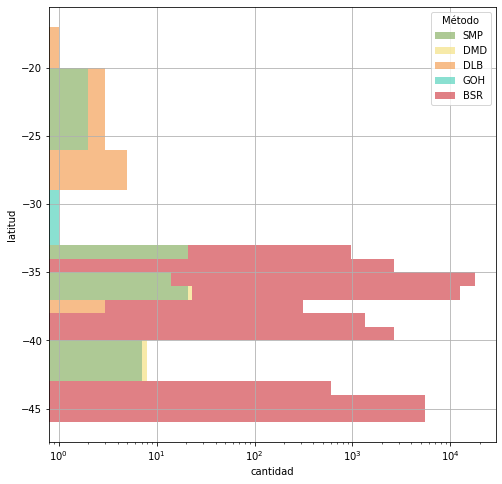

In [135]:
fig,ax=plt.subplots( figsize=(8,8))
bins=np.array(lat_seg)

#Se calcula el ajuste para descartar aquellos puntos fuera del área de estudio
hf_df['ajuste']=ajuste_calorico('Q', tau_NCCW(0.94))
a=hf_df[~np.isnan(hf_df.ajuste)].copy()

tip1=a[a.metodo==1].copy()
tip2=a[a.metodo==2].copy()
tip3=a[a.metodo==3].copy()
tip4=a[a.metodo==4].copy()
tip5=a[a.metodo==5].copy()

ax.hist([tip1.lat, tip2.lat, tip3.lat, tip4.lat ,tip5.lat], sorted(bins), log=True, 
        orientation='horizontal', histtype='barstacked',
        color=[(140/255,179/255,105/255),
               (244/255,226/255,133/255),
               (244/255,162/255,89/255),
               (88/255,211/255,190/255),
               (211/255,75/255,81/255)], 
        alpha=0.7, label=['SMP','DMD','DLB','GOH','BSR'])
ax.grid()
ax.legend(title='Método')
ax.set_ylabel('latitud')
ax.set_xlabel('cantidad')
ax.set_xlim(0.8)

pass

---

## Ajuste de Flujo de Calor - Perfiles e Histogramas

In [41]:
def get_keys(dic):
    for i in dic.keys():
        return i

def list_objs(**kwards):
    # kwards debe ser un diccionario con el parámetro a evaluar (keys) y sus posibles valores como listas(values)
    # El diccionario está hecho para un keys solamente (por ahora...)
    list_=[]
    for key, values in kwards.items():
        count=1
        for i in values:
            new_dict={key:i}
            obj=Test(nombre='Objeto {}'.format(count), **new_dict)
            list_.append(obj)
            count+=1
    return list_

In [42]:
def histogram_Q(kwargs, ax, rango_latitud, colors):
    plt.figure('Nombre Figura')
    
    means=[]
    stds=[]
    
    for v, c in zip(kwargs['tau'], colors):
        hf_df['ajuste']=ajuste_calorico('Q', v)
        
        df=hf_df[(hf_df.lat < max(rango_latitud)) & (hf_df.lat > min(rango_latitud))].copy()
        
        std=np.nanstd(df.ajuste)
        stds.append(std)
        mean=np.nanmean(df.ajuste)
        means.append(mean)
        
        if len(df.ajuste)>100:
            n_bins=100
        elif len(df.ajuste)>50:
            n_bins=50
        elif len(df.ajuste)>10:
            n_bins=10
        else:
            n_bins=len(df.ajuste)
            
        try:
            ax.hist(df.ajuste, bins=n_bins, color=c, alpha=0.7)
        except ValueError:
            print(df[~np.isnan(df.ajuste)])
    
    if std!=0:
        ax.set_xlim(np.nanmin(means)-3*np.nanmean(stds), np.nanmax(means)+3*np.nanmean(stds))
    
    ax.set_ylabel('Cantidad')    
    ax.set_xlabel('$\Delta Q$'+' [%]')
    return ax

In [43]:
def graf_comparacion(TauPoros, secuencia , rango_latitud, vista='complejo'):
    #la variable vista puede ser 'simple' (un solo perfil como promedio) o 'compleja' (todos los perfiles del rango de latitud)
    
    fig =plt.figure('Nombre Figura', figsize=(10,8))
    
    spec = matplotlib.gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])
    
    if TauPoros == 'tau':
        kwargs={'tau':secuencia}
    elif TauPoros == 'poros':
        kwargs={'tau':[tau_NCCW(i) for i in secuencia]}
    
    objetos=list_objs(**kwargs)
    df_plotear=[]
    nombres=[]
    right=[]
    left=[]
    up=[]
    
    for i in objetos:
        #Creo una lista con los dataframes a plotear filtrados según la latitud requerida
        x=np.array(getattr(i, 'distancia'))
        y=np.array(getattr(i, 'Q'))
        z=np.array(getattr(i, 'lat'))
        
        d={'distancia' : x  , 'Q' : y, 'lat':z}
        df=pd.DataFrame(data=d) #paso a DF porque es más fácil filtrar
        df_val= df.loc[(df['lat']>min(rango_latitud)) & (df['lat']<max(rango_latitud))].copy()
        df_val.dropna(inplace=True)
        df_val.sort_values(['lat','distancia'], inplace=True)
        df_plotear.append(df_val)
    
        nombres.append(i.nombre)
        
    etiquetas=[]
    handles=[]
    
    colores=[(27/255,153/255,139/255), (46/255,41/255,78/255), (251/255,38/255,61/255)]
    if TauPoros=='tau':
        colores=colores
    else:
        colores=[i for i in reversed(colores)]

    col=0
    for d,k in zip(df_plotear, secuencia):    
        
        etiquetas.append(k)
        
        distancia_maxima=[]
        
        for i,j, la in zip(d.distancia ,d['Q'], d.lat):
            plotear=d[d.lat==la].copy()
            line,=ax1.plot(plotear.distancia, plotear.Q, color=colores[col])
                    
            distancia_maxima.append(np.nanmax(plotear.distancia))
                
            right.append(np.nanmax(plotear.distancia))
            left.append(np.nanmin(plotear.distancia))
            up.append(np.nanmax(plotear.Q))
            
        col+=1
        handles.append(line)
    
    
    #Filtrado de datos de calor según latitud requerida
    #d_hf={'distancia' : hf_df.distancia , 'lat':hf_df.lat , 'Q' : hf_df.Q, 'method':hf_df.metodo}
    #df_hf=pd.DataFrame(data=d_hf)
    
    #df_hf['ajuste']=ajuste_calorico('Q', tau_NCCW(0.94))
    #hf_df=hf_df[~np.isnan(hf_df.ajuste)].copy()
    
    df_plot= hf_df[(hf_df.lat>min(rango_latitud)) & (hf_df.lat<max(rango_latitud))].copy()

    tip1=df_plot[df_plot.metodo==1].copy()
    tip2=df_plot[df_plot.metodo==2].copy()
    tip3=df_plot[df_plot.metodo==3].copy()
    tip4=df_plot[df_plot.metodo==4].copy()
    tip5=df_plot[df_plot.metodo==5].copy()
    
    t1=ax1.scatter(tip1.distancia, tip1.Q, c=(140/255 , 179/255 , 105/255), zorder=4)
    t2=ax1.scatter(tip2.distancia, tip2.Q, c=(244/255 , 226/255 , 133/255), zorder=4)
    t3=ax1.scatter(tip3.distancia, tip3.Q, c=(244/255 , 162/255 , 89/255), zorder=4)
    t4=ax1.scatter(tip4.distancia, tip4.Q, c=(88/255  , 211/255 , 190/255), zorder=4)
    t5=ax1.scatter(tip5.distancia, tip5.Q, c=(211/255 , 75/255  , 81/255), zorder=4)
    
    legenda_puntos=ax1.legend(handles=[t1,t2,t3,t4,t5], labels=['SMP','DMD','DLB','GOH','BSR'], title='Método',
                              bbox_to_anchor=(1, 0.55), loc='center left', borderaxespad=0.3)
    ax1.add_artist(legenda_puntos)
    ax1.set_title(str(abs(max(rango_latitud))) + '-' + str(abs(min(rango_latitud))) + '°S',
                 pad=20, size='xx-large')
    ax1.set_ylabel('Q' + ' [mW/m\u00b2]')
    ax1.set_xlabel('Distancia fosa [km]')    
    ax1.grid()
    
    ax1.set_xlim(0, max(right)+10)
    ax1.set_ylim(0, max(up)+max(up)/10)
        
    if TauPoros=='tau':
        ax1.legend(handles, etiquetas, title= '$\\tau$'+' [MPa]', 
                   bbox_to_anchor=(1, 0.9), loc='center left', borderaxespad=0.3)
    else:
        ax1.legend(handles, etiquetas, title= '$\lambda$', 
                   bbox_to_anchor=(1, 0.9), loc='center left', borderaxespad=0.3)

    histogram_Q(kwargs, ax2, rango_latitud, colores)
    
    plt.show()
    
    return fig

##### La función graf_comparacion tiene 4 atributos:
- **TauPoros**: define el escenario a evaluar
        -'tau' para cizalle constante
        -'poros' para cizalle variable dependiente de la razón de presión de poros

- **secuencia**: como lista, defina los valores de $\tau$ o $\lambda$ que se quieran plotear


- **rango_latitud**: debe tener una longitud igual a 2. Rango de latitudes que se quiera plotear
    Rangos recomendados:
        - (-17,-20)
        - (-20,-23)
        - (-23,-26)
        - (-26,-29)
        - (-29,-33)
        - (-33,-34)
        - (-34,-35)
        - (-35,-36)
        - (-36,-37)
        - (-37,-38)
        - (-39,-40)
        - (-40,-43)
        - (-43,-46)
        
- **vista**: dos opciones
        -'complejo' (default) para ver todos los perfiles en el rango de latitudes selecionadas
        -'simple' para ver el promedio de los perfiles dentro del rango de latitudes

---

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

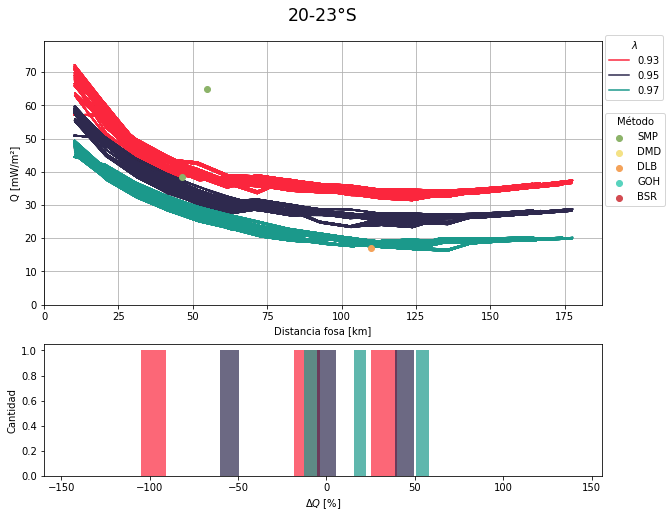

In [136]:
graf_comparacion('poros', [0.93, 0.95, 0.97], (-20,-23))
pass

---

## Ajuste Flujo de Calor - Tablas Resumen

In [45]:
def por_lat(attr,tau, kc=2.5, tp=1350, dip=dip): 
    porc=ajuste_calorico(attr, tau, kc=kc, tp=tp, dip=dip)
    
    d={'lat': hf_object.lat, 'porc':porc}
    df=pd.DataFrame(d)
    
    promedio=[]
    D_Estandar=[]
    
    for i in range(len(lat_seg)-1):
        df_filt=df[(df.lat <= lat_seg[i]) & (df.lat >= lat_seg[i+1])].copy()  
        nans=~np.isnan(df_filt.porc)
        calc=np.array(df_filt.porc[nans])
        
        if len(calc) != 0:
            stand=np.std(calc)
            D_Estandar.append(stand)
            prom=np.nanmean(calc)
            promedio.append(prom)
        else:
            D_Estandar.append(np.nan)
            promedio.append(np.nan)
            
    return promedio, D_Estandar

In [46]:
def df_HeatMap(attr, secuencia, tipo='tau', kc=2.5, tp=1350, dip=dip):
    lati=[]
    for c in range(len(lat_seg)-1):
        lati.append((lat_seg[c], lat_seg[c+1]))
    
    df=pd.DataFrame(index=lati)

    if tipo=='tau':
        for i in secuencia:
            p,s =por_lat(attr,i, kc=kc, tp=tp, dip=dip)
            df[str(i)]=p
    
    elif tipo=='poros':
        for i in secuencia:
            tau=tau_NCCW(i)
            p,s =por_lat(attr, tau, kc=kc, tp=tp, dip=dip)
            df[str(i)]=p
                
    return df, s

In [138]:
secuencia_taus=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
df_Molnar, desv_std = df_HeatMap('Q', secuencia_taus)

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site

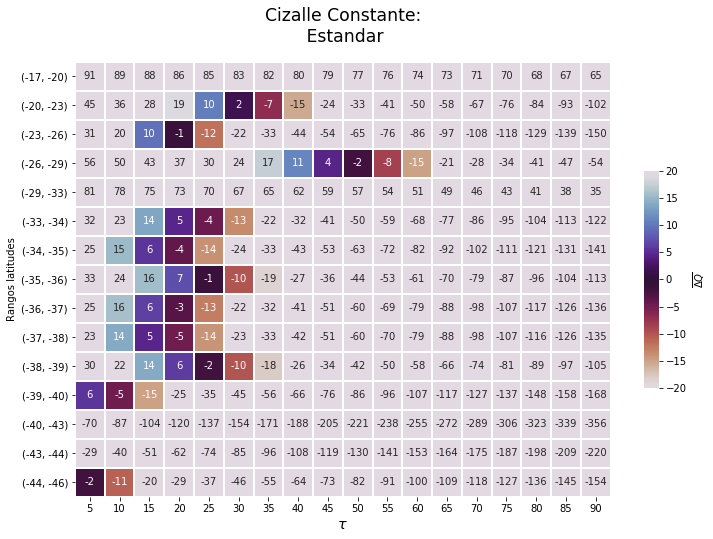

In [48]:
plt.figure(figsize=(12,8))
sns.heatmap(df_Molnar, vmin=-20, vmax=20, cmap='twilight_r', center=0, robust=True, 
            annot=True, linewidths=1, fmt='.0f',
            cbar_kws={'shrink':0.5, 'aspect':15, 'label':'$\overline{\Delta Q}$'})
plt.title('Cizalle Constante:\n Estandar', pad=20, size='xx-large')
plt.ylabel('Rangos latitudes')
plt.xlabel('$\\tau$', size='x-large')
pass

In [140]:
presion_fluidos=[0.80, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]
df_Poros, d_std = df_HeatMap('Q', presion_fluidos, 'poros')

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Laptop Lenovo\anaconda3\lib\site

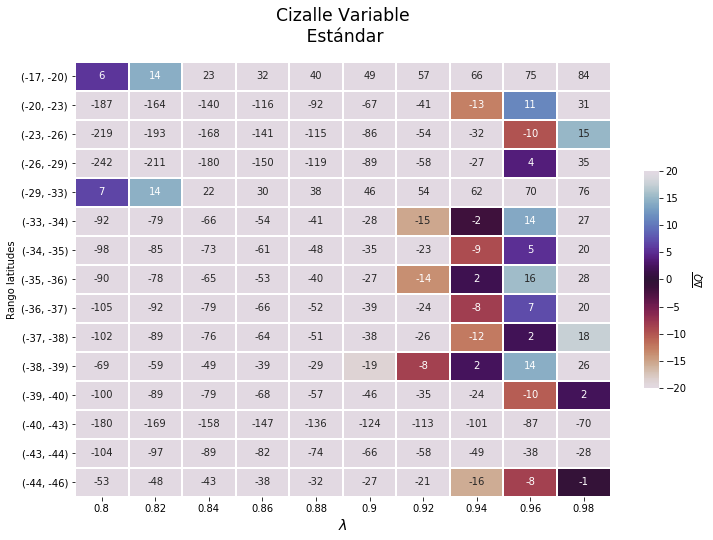

In [141]:
plt.figure(figsize=(12,8))
sns.heatmap(df_Poros, vmin=-20, vmax=20, cmap='twilight_r', center=0, 
            annot=True, linewidths=1, fmt='.0f',
            cbar_kws={'shrink':0.5, 'aspect':15, 'label':'$\overline{\Delta Q}$'})
plt.title('Cizalle Variable\n Estándar', pad=20, size='xx-large')
plt.ylabel('Rango latitudes')
plt.xlabel('$\lambda$', size='x-large')
pass

---

## Mapas

Estas funciones son para plotear el atributo que desee, desde 1 hasta 4 mapas a la vez. Solo se deben definir previamente los objetos.

In [51]:
def ploteo_simple(objeto, attr, fig=None, position=(1,1,1), colormap='hot_r',step=50, other=False,
                 add_vminmax=(False, None, None)):
    # <attr> debe ser un str. Corresponde al nombre del atributo (del objeto) que plotearé
    
    fig1= plt.figure('NombreFigura', figsize=(5,15))
    ax = fig1.add_subplot(position[0],position[1],position[2])

    x=objeto.lon
    y=objeto.lat
    z=getattr(objeto, attr)
    
    if attr=='tau':
        z=z*objeto.anti_corregir('tau')
    
    #Interpolación
    xi=np.linspace(-77.5, -65, 100)
    yi=np.linspace(-47, -15, 100)
    triang=tri.Triangulation(x,y)
    interpolation=tri.LinearTriInterpolator(triang,z)
    Xi, Yi=np.meshgrid(xi,yi)
    zi= interpolation(Xi,Yi)
    
    if add_vminmax[0]==True:
        vmin=add_vminmax[1]
        vmax=add_vminmax[2]
    
    else:
        vmin=np.nanmin(z)
        vmax=np.nanmax(z)
    
    if other==False:
        niveles=np.arange(0,vmax, step)
        niveles_T1=[100,450]
        niveles_T2=[150,350]
        
        ax.contour(xi, yi, zi, levels=niveles_T1, colors='k')
        ax.contour(xi, yi, zi, levels=niveles_T2, colors='k', linestyles='dotted')
        contornos=ax.contourf(xi,yi,zi, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    SA_shape.plot(color='none',edgecolor='0.7', ax=ax, zorder=2)
    trench.plot(color='k', ax=ax, lw=0.8)
    
    #Ajuste grillas
    ax.set_xlim(-77.5, -68)
    ax.set_ylim(-46, -16)
    ax.grid()
    ax.set_title(objeto.nombre, pad=20, size='xx-large', wrap=True)
    if position[2]==1:
        ax.set_ylabel(objeto.ticks['lat'])
    ax.set_xlabel(objeto.ticks['lon'])
    
    if other==False:
            clb=fig1.colorbar(contornos, ax=ax, use_gridspec=True, shrink=0.5)
            clb.ax.set_title(objeto.measure_unit[attr], pad=20)

    return ax, xi, yi, zi, z, fig1

In [52]:
def ploteo_doble(objeto1, objeto2, attr, colormap='hot_r',step=50, add_vminmax=(False, None, None)):
    # <attr> debe ser un str. Corresponde al nombre del atributo (del objeto) que plotearé
    
    fig = plt.figure('NombreFigura', figsize=(15,15))
    
    #ejes
    ax1, x1, y1, z1, z_attr1,_= ploteo_simple(objeto1, attr, fig, position=(1,2,1), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax2, x2, y2, z2, z_attr2,_= ploteo_simple(objeto2, attr, fig, position=(1,2,2), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    
    #barplot
    vmax=np.nanmax(list(z_attr1)+list(z_attr2))
    vmin=np.nanmin(list(z_attr1)+list(z_attr2))
    
    if step==None:
        niveles=np.linspace(0,vmax, 8)
    else:
        niveles=np.arange(0,vmax, step)
        niveles_T1=[100,450]
        niveles_T2=[150,350]
    
    ax1.contour(x1, y1, z1, levels=niveles_T1, colors='k')
    ax1.contour(x1, y1, z1, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos1=ax1.contourf(x1,y1,z1, levels=niveles, cmap=colormap, vmin=vmin, vmax=vmax)
    
    ax2.contour(x2, y2, z2, levels=niveles_T1, colors='k')
    ax2.contour(x2, y2, z2, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos2=ax2.contourf(x2,y2,z2, levels=niveles, cmap=colormap, vmin=vmin, vmax=vmax)
    
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels=[])
    
    if vmax==np.nanmax(z_attr1):
        contornos=contornos1 
    else:
        contornos=contornos2
    
    axins1 = inset_axes(ax2,
                    width="5%",
                    height="30%", 
                    loc='lower right')
    clb=fig.colorbar(contornos, cax=axins1, ticks=np.arange(0,vmax,step*2))
    clb.ax.set_title(objeto1.measure_unit[attr])
    axins1.yaxis.set_ticks_position("left")
    
    plt.subplots_adjust(left=0.12,
                    bottom=0.12, 
                    right=0.90, 
                    top=0.9, 
                    wspace=-0.6, 
                    hspace=0.2)
    
    plt.show()
    return fig

In [53]:
def ploteo_triple(objeto1, objeto2, objeto3, attr, colormap='hot_r',step=50, add_vminmax=(False, None, None)):
    fig = plt.figure('NombreFigura', figsize=(20,30))
    
    #ejes
    ax1, x1, y1, z1, z_attr1,_= ploteo_simple(objeto1, attr, fig, position=(1,3,1), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax2, x2, y2, z2, z_attr2,_= ploteo_simple(objeto2, attr, fig, position=(1,3,2), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax3, x3, y3, z3, z_attr3,_= ploteo_simple(objeto3, attr, fig, position=(1,3,3), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    
    vmax=np.nanmax(list(z_attr1)+list(z_attr2)+list(z_attr3))
    
    niveles=np.arange(0,vmax,step)
    if attr== 'T':
        niveles_T1=[100,450]
        niveles_T2=[150,350]
    else:
        niveles_T1=None
        niveles_T2=None
    
    ax1.contour(x1, y1, z1, levels=niveles_T1, colors='k')
    ax1.contour(x1, y1, z1, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos1=ax1.contourf(x1,y1,z1, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    ax2.contour(x2, y2, z2, levels=niveles_T1, colors='k')
    ax2.contour(x2, y2, z2, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos2=ax2.contourf(x2,y2,z2, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    ax3.contour(x3, y3, z3, levels=niveles_T1, colors='k')
    ax3.contour(x3, y3, z3, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos3=ax3.contourf(x3,y3,z3, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    if vmax==np.nanmax(list(z_attr1)):
        contornos=contornos1
    elif vmax==np.nanmax(list(z_attr2)):
        contornos=contornos2
    else:
        contornos=contornos3
    
    clb=fig.colorbar(contornos, ax=[ax1,ax2,ax3], use_gridspec=True, shrink=0.25, aspect=30, orientation='vertical')
    clb.ax.set_title(objeto1.measure_unit[attr], pad=20)
    
    return fig

In [54]:
def ploteo_cuadruple(objeto1, objeto2, objeto3, objeto4, attr, colormap='hot_r',step=50, add_vminmax=(False, None, None)):
    
    fig = plt.figure('NombreFigura', figsize=(10,30))
    
    #modelo15=Test(nombre='T15', tau=15)
    #modelo25=Test(nombre='T25', tau=25)
    #modelo94=Test(nombre='L94', tau=tau_NCCW(0.94))
    #modelo96=Test(nombre='L96', tau=tau_NCCW(0.96))
    
    #ejes
    ax1, x1, y1, z1, z_attr1,_= ploteo_simple(objeto1, attr, fig, position=(2,2,1), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax2, x2, y2, z2, z_attr2,_= ploteo_simple(objeto2, attr, fig, position=(2,2,2), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax3, x3, y3, z3, z_attr3,_= ploteo_simple(objeto3, attr, fig, position=(2,2,3), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    ax4, x4, y4, z4, z_attr4,_= ploteo_simple(objeto4, attr, fig, position=(2,2,4), colormap=colormap, step=step, other=True,
                                             add_vminmax=add_vminmax)
    
    vmax=np.nanmax(list(z_attr1)+list(z_attr2)+list(z_attr3)+list(z_attr4))
    
    niveles=np.arange(0,vmax, step)
    if attr== 'T':
        niveles_T1=[100,450]
        niveles_T2=[150,350]
    else:
        niveles_T1=None
        niveles_T2=None
    
    ax1.contour(x1, y1, z1, levels=niveles_T1, colors='k')
    ax1.contour(x1, y1, z1, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos1=ax1.contourf(x1,y1,z1, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    ax2.contour(x2, y2, z2, levels=niveles_T1, colors='k')
    ax2.contour(x2, y2, z2, levels=niveles_T2, colors='k', linestyles='dotted')
    ax2.set_ylabel('')
    contornos2=ax2.contourf(x2,y2,z2, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    ax3.contour(x3, y3, z3, levels=niveles_T1, colors='k')
    ax3.contour(x3, y3, z3, levels=niveles_T2, colors='k', linestyles='dotted')
    contornos3=ax3.contourf(x3,y3,z3, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    ax4.contour(x4, y4, z4, levels=niveles_T1, colors='k')
    ax4.contour(x4, y4, z4, levels=niveles_T2, colors='k', linestyles='dotted')
    ax4.set_ylabel('')
    contornos4=ax4.contourf(x4,y4,z4, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)
    
    clb=fig.colorbar(contornos4, ax=[ax1,ax2,ax3,ax4], use_gridspec=True, shrink=0.25, aspect=30, orientation='vertical')
    clb.ax.set_title(objeto1.measure_unit[attr], pad=20)
    
    return fig

In [55]:
L94=Test(nombre='L94', tau=tau_NCCW(0.94))
L96=Test(nombre='L96', tau=tau_NCCW(0.96))
T15=Test(nombre='T15', tau=15)
T25=Test(nombre='T25', tau=25)

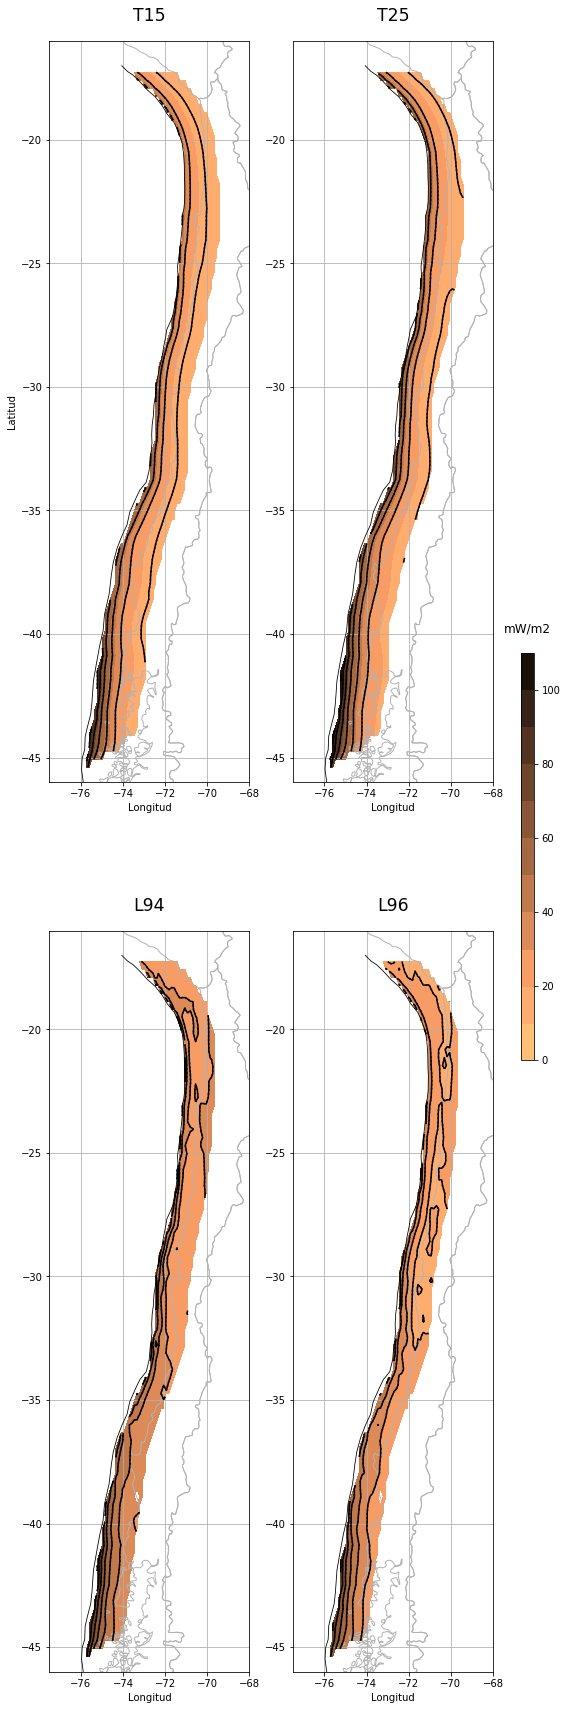

In [142]:
ploteo_cuadruple(T15, T25, L94, L96, 'Q', step=10, colormap='copper_r')
pass

In [57]:
def map_comparacion(estandar, objeto1, objeto2, attr, colormap='pink_r', step=None, add_vminmax=(False, None, None)):
    #step: cada cuanto se hacen las cotas
    fig = plt.figure('NombreFigura', figsize=(15,15))
    
    comparacion1=Test(nombre=estandar.nombre + ' - ' + objeto1.nombre)
    z1=getattr(estandar,attr)-getattr(objeto1,attr)
    setattr(comparacion1, attr, abs(z1))
    
    comparacion2=Test(nombre=estandar.nombre + ' - ' + objeto2.nombre)
    z2=getattr(estandar,attr)-getattr(objeto2,attr)
    setattr(comparacion2, attr, abs(z2))
    
    ax1,x1,y1,z1,z_attr1,_ =ploteo_simple(comparacion1, attr, fig, position=(1,2,1), colormap=colormap, step=step, 
                                          other=True, add_vminmax=add_vminmax)
    ax2,x2,y2,z2,z_attr2,_ =ploteo_simple(comparacion2, attr, fig, position=(1,2,2), colormap=colormap, step=step, 
                                          other=True, add_vminmax=add_vminmax)
    
    vmax=np.nanmax(list(z_attr1)+list(z_attr2))
    
    if step==None:
        niveles=np.linspace(0,vmax,7)
    else:
        niveles=np.arange(0, vmax, step)
    
    ax1.contour(x1, y1, z1, levels=niveles, colors='k', linestyles='dotted')
    contornos1=ax1.contourf(x1,y1,z1, levels=niveles, cmap=colormap , vmin=0, vmax=vmax)
    
    ax2.contour(x2, y2, z2, levels=niveles, colors='k', linestyles='dotted')
    contornos2=ax2.contourf(x2,y2,z2, levels=niveles, cmap=colormap, vmin=0, vmax=vmax)

    if vmax==np.nanmax(z_attr1):
        contornos=contornos1
    else:
        contornos=contornos2
        
    clb=fig.colorbar(contornos, ax=[ax1,ax2], use_gridspec=True, shrink=0.25, aspect=30, orientation='vertical')
    clb.ax.set_title('$\Delta°C$', pad=20)
    
    plt.show()
    return fig

In [58]:
T20=Test(nombre='T20', tau=20)

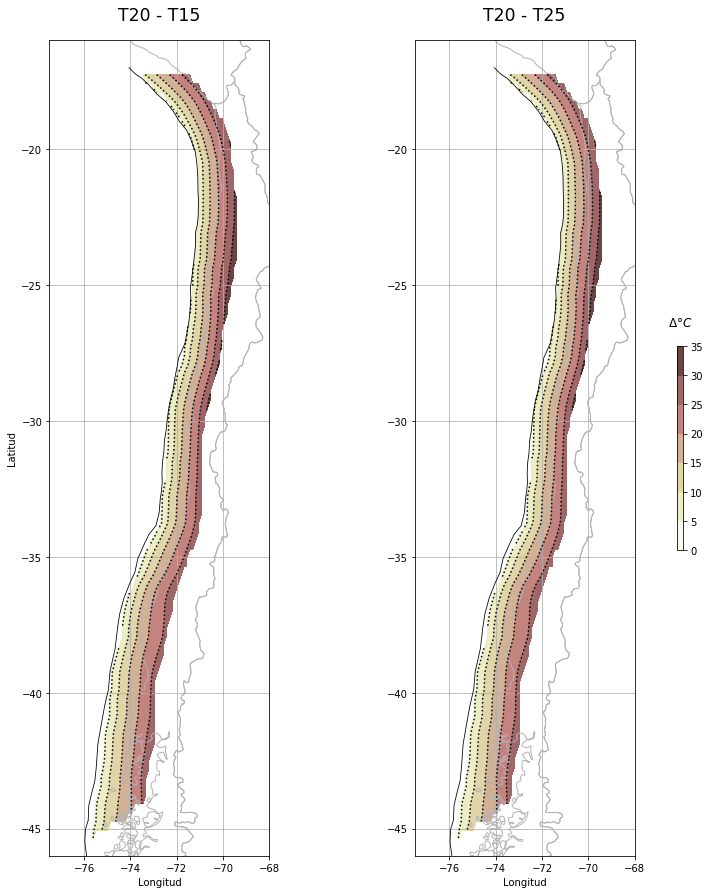

In [59]:
map_comparacion(T20,T15,T25,'T', step=5)
pass

---

## Distribución Temepratura y Sismicidad

In [60]:
def Temperature_set(df_filtrado, tau=30):
    #Devuelve un array con las temperaturas de los sismos
    calculado=Test(tau=tau)
    df_filtrado=df_filtrado
    T=[]
    for ixs in df_filtrado.ix_Grilla:
        T_ixs=[]
        try:
            for i in ixs:
                T_ixs.append(calculado.T[i])
        except KeyError:
            T_ixs.append(np.nan)
        except TypeError:
            T_ixs.append(calculado.T[ixs])
           
        mean=np.nanmean(T_ixs)
        T.append(mean)
    return np.array(T)

In [61]:
def histogram_T(df_filtrado,  Moho_filt, v_tau, Titulo, share_x=None, share_y=None, position=1):
    fig, ax=plt.subplots(figsize=(8,5))
    
    '''fig=plt.figure('Nombre Figura')
    if position==1 or position==4:
        ax=fig.add_subplot(2,2, position)
    if position==2 or position==3:
        ax=fig.add_subplot(2,2, position, sharex=share_x, sharey=share_y)
    '''    
    
    df_filtrado['T']=Temperature_set(df_filtrado, v_tau)
    df_filtrado=df_filtrado[~np.isnan(df_filtrado['T'])].copy()
    
    Moho_filt['T']=Temperature_set(Moho_filt, v_tau)
    Moho_mean=np.nanmean(Moho_filt['T'])
    
    N, bins, patches = pl.hist(df_filtrado['T'], bins=np.arange(0, df_filtrado['T'].max(), 10), color='0.7')
    
    decil=np.percentile(df_filtrado['T'],np.arange(0,100,10))
    
    anchored_text = AnchoredText('10%: {}°C \n90%: {}°C'.format(round(decil[1],1), round(decil[-1],1)),
                                 loc='upper right', prop={'size':'xx-large'}, frameon=True)
    
    ax.add_artist(anchored_text)

    '''
    if position==1 or position==3:
        ax.set_ylabel('Cantidad')
    if position==3 or position==4:
        ax.set_xlabel('Temperatura [°C]')
    '''
    ax.set_ylabel('Cantidad', size='x-large')
    ax.set_xlabel('Temperatura [°C]', size='x-large')
    ax.tick_params(labelsize='x-large')
    #ax.set_title(Titulo, size='x-large')
    
    plt.axvline(x=decil[1], ymin=0.0, ymax=1, color='k', ls=':')
    plt.axvline(x=decil[-1], ymin=0.0, ymax=1, color='k', ls=':')
    plt.axvline(x=Moho_mean, ymin=0.0, ymax=1, color='b', lw=0.6)
    
    return ax

In [143]:
def sismos_vs_T(rango_latitud, modelo, magnitud_min):
    df_filtrado=data_sismos[(data_sismos.lat <= max(rango_latitud)) & (data_sismos.lat >= min(rango_latitud)) &
                          (data_sismos.mag >= magnitud_min) & (data_sismos.intercorticales == True)].copy()
    
    Moho_filtrado=Moho[(Moho.lat>min(rango_latitud)) & (Moho.lat<max(rango_latitud))].copy()
    
    fig=plt.figure('Nombre Figura', figsize=(20,10))
    
    if modelo=='T20':
        ax=histogram_T(df_filtrado, Moho_filtrado, 20, 'T20')
    elif modelo=='L95':
        ax=histogram_T(df_filtrado, Moho_filtrado, tau_NCCW(0.95), 'L95')
    else:
        print('escribe bien')
    
    return fig

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


<Figure size 1440x720 with 0 Axes>

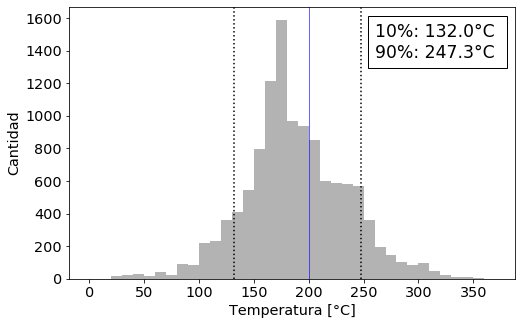

In [63]:
a=sismos_vs_T((-17,-46), 'T20', 3)

---

## Potencia Sísmica

In [64]:
def Pot_Sis (evento, grados=10):
    m=slips[slips.locality == evento].copy()
    m['L95']=Temperature_set(m, tau_NCCW(0.95))
    m['T20']=Temperature_set(m, 20)
    m['pot_sismica']=m.pot_sismica*10**6 # unidad de medida [metro]
    c_valor=m[~np.isnan(m.pot_sismica)].copy()

    Tempes=['T20', 'L95']

    fig, ax=plt.subplots(figsize=(15,5))

    for t in Tempes: 
        lim_bines=np.arange(0, np.nanmax(getattr(c_valor, t)),grados)
        bines=lim_bines-[grados/2 for i in range(len(lim_bines))]

        potencias=[]
        for i in range(len(bines)-1):
            pot=c_valor[(getattr(c_valor,t)>lim_bines[i]) & (getattr(c_valor,t)<lim_bines[i+1])].copy()
            suma_pot_sismica=np.sum(pot.pot_sismica)
            potencias.append(suma_pot_sismica)
    
    
        ax.plot(bines[1:], potencias, label=t)
        #ax.scatter(bines[1:], potencias)

    ax.set_xlabel('Temperatura [°C]', size='large')
    ax.set_ylabel('Potencia Sísmica [m\u00b3]', size='large')
    ax.legend()
    
    for i in lim_bines:
        plt.axvline(x=i, ymin=0.0, ymax=1, color='k', ls=':', lw=0.8)
    for i in bines:
        plt.axvline(x=i, ymin=0.0, ymax=1, color='k', ls=':', lw=0.4)
    
    ax.grid()
    plt.show()
    
    return fig

Calcula la potencia sísmica para los dos modelos propuestos por este trabajo

Las opciones en **evento** son las siguientes:
- Antofa95
- Illapel15
- Iquique14
- Maule10
- Tocopilla07
- Valdivia60

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


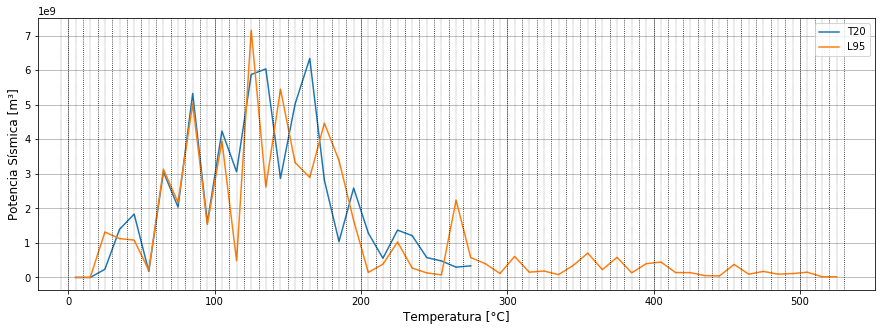

In [144]:
Pot_Sis('Illapel15',10)
pass

---

## Sismicidad por Segmento de Segundo orden

Incluye la sismicidad y los contornos de slip cosísmicos

In [66]:
eventos_dict={'evento':epicentros['Earthquake'], 'epicentro':epicentros['geometry'], 'contorno_slip':[1,1,0.5,1,2,4]}
eventos_df=pd.DataFrame(eventos_dict)

In [67]:
Segundo_ord={'Altiplano':[-17,-23,-73.75,-69.25], 'Puna':[-23,-28,-72.25,-69.25], 'Frontal':[-28,-33,-73,-70],
             'Principal':[-33,-39,-75,-70.75], 'Patagonica':[-39,-46,-76.25,-72.7]}

In [68]:
def segmento (segmento, termal_model, mag=3, step_t=50):
    
    top=Segundo_ord[segmento][0]
    bottom=Segundo_ord[segmento][1]
    left=Segundo_ord[segmento][2]
    right=Segundo_ord[segmento][3]
    
    if termal_model=='T20':
        modelo = Test(nombre='T20', tau=20)
    elif termal_model=='L95':
        modelo = Test(nombre='L95', tau=tau_NCCW(0.95))
    else:
        print('Escribe bien el nombre')
    
    fig = plt.figure('NombreFigura', figsize=(5,13))
    
    ax1,x1,y1,z1,v_z1,_ = ploteo_simple(modelo, 'T', fig, position=(1,1,1), other=True)
    
    #MAPAS DE CALOR
    vmax=np.nanmax(v_z1)
    
    niveles_t=np.arange(0,vmax, step_t)
    
    ax1.contour(x1, y1, z1, levels=(100,450), colors='k')
    ax1.contour(x1, y1, z1, levels=(150,350), colors='k', linestyles='dashed')
    contornos1=ax1.contourf(x1,y1,z1, levels=niveles_t, cmap='hot_r', vmin=0, vmax=vmax)
    lim_moho.plot(ax=ax1, color='cornflowerblue')
    
    if vmax==np.nanmax(v_z1):
        contornos=contornos1
    
    elif vmax==np.nanmax(v_z2):
        contornos=contornos2
    
    elif vmax==np.nanmax(v_z3):
        contornos=contornos3
        
    else:
        contornos=contornos4
    
    axins1 = inset_axes(ax1,
                    width="5%",
                    height="30%", 
                    loc='center left')
    clb=fig.colorbar(contornos, cax=axins1, ticks=np.arange(0,vmax,100))
    clb.ax.set_title('°C')
    
    #CONTORNO DE TERREMOTO
    for i in eventos_df.evento:
        
        df=slips[slips.locality==i].copy()
        epi=epicentros[epicentros.Earthquake==i].copy()
    
        xi=np.linspace(np.nanmin(getattr(df, 'lon')), np.nanmax(getattr(df, 'lon')), 100)
        yi=np.linspace(np.nanmin(getattr(df, 'lat')), np.nanmax(getattr(df, 'lat')), 100)
        triang=tri.Triangulation(getattr(df, 'lon'), getattr(df, 'lat'))
        interpolation=tri.LinearTriInterpolator(triang, getattr(df, 'meters'))
        Xi, Yi=np.meshgrid(xi,yi)
        zi= interpolation(Xi,Yi)
    
        niveles=np.arange(1, np.nanmax(df.meters)+1, float(eventos_df[eventos_df.evento==i].contorno_slip))
    
        ax1.contour(xi,yi,zi, levels=niveles, zorder=3)
        epi.plot(ax=ax1, marker='*', markersize=500, color='limegreen', zorder=2)
        
    #SISMOS
    sis=sismos_thrust[(sismos_thrust.mag>mag)&(sismos_thrust.lon<right)&(sismos_thrust.lon>left)&
                     (sismos_thrust.lat<top)&(sismos_thrust.lat>bottom)].copy()
    
    x=sis.lon
    y=sis.lat
    z=sis.mag
    
    scatter = ax1.scatter(x,y, s=z, alpha=0, zorder=1)
    labels_mag=np.arange(mag,np.nanmax(z))
    _,labels = scatter.legend_elements(prop="sizes", num=labels_mag, alpha=0.6)
    
    scatter = ax1.scatter(x,y, facecolors='none', edgecolors='dimgrey', s=(2**z)*2, alpha=1, zorder=1)
    handles,_= scatter.legend_elements(prop="sizes", num=len(labels_mag), alpha=1, mfc='none', mec='dimgrey')
    
    legend2 = ax1.legend(handles, labels, loc="upper left", title="Mw")
    
    #LÍMITES
    ax1.set_ylim(bottom, top)
    ax1.set_xlim(left, right)
    
    a=ax1.get_xticks()
    ax1.set_xticks(a)
    
    return fig

El parámetro **termal_model** solo admite T20 y L95

C:\Users\Laptop Lenovo\anaconda3\lib\site-packages\matplotlib\collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


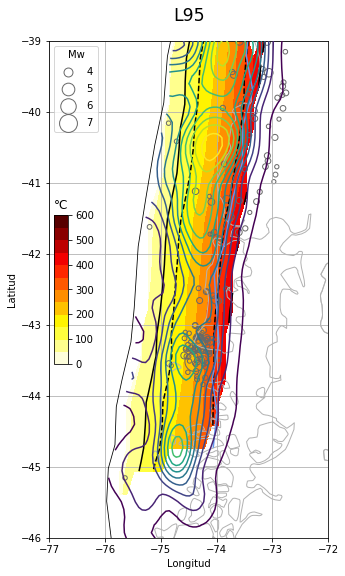

In [69]:
a=segmento('Patagonica', 'L95',3)

---

## Manteo Promedio

Se define un modelo para delimitar al área de estudio

In [70]:
T15=Test(nombre='T15', tau=15)
manteos=T15.dip[~np.isnan(T15.T)]*T15.anti_corregir('dip')

Text(0, 0.5, 'Cantidad')

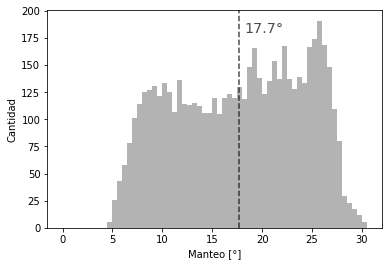

In [71]:
fig,ax=plt.subplots()
mean=np.nanmean(manteos)
ax.hist(manteos, bins=np.arange(0,np.nanmax(manteos),0.5), color='0.7')
ax.axvline(mean, c='k', alpha=0.7, ls='--')
ax.text(mean+0.5, 180, str(round(mean,1))+'°', size='x-large', c='k', alpha=0.7)
ax.set_xlabel('Manteo [°]')
ax.set_ylabel('Cantidad')

In [72]:
manteos.describe()

count    5770.000000
mean       17.721045
std         6.432863
min         4.743820
25%        12.047875
50%        18.294200
75%        23.321750
max        30.679900
Name: dip, dtype: float64